In [1]:
import numpy as np
import ghalton
import copy

from keras import layers
from keras import models
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
call_option = "call"
put_option = "put"

knock_in = "in"
knock_out = "out"
barrier_up = "up"
barrier_down = "down"


def EU_Monte_Carlo(model, paths):
    price = 0
    if model.option_type == call_option:
        price = paths[:, -1] - model.K
    elif model.option_type == put_option:
        price = model.K - paths[:, -1]
    else:
        pass
    price = np.where(price > 0, price, 0)
    return np.exp(-model.r * model.T) * np.mean(price)


def AM_Monte_Carlo(model, paths):
    price = np.zeros_like(paths)
    step_num = price.shape[1]
    delta_t = model.T / step_num
    if model.option_type == call_option:
        tmp = paths[:, -1] - model.K
        price[:, -1] = np.where(tmp > 0, tmp, 0)
    elif model.option_type == put_option:
        tmp = model.K - paths[:, -1]
        price[:, -1] = np.where(tmp > 0, tmp, 0)
    for idx in range(2, step_num + 1):
        back_val = np.exp(-model.r * delta_t) * price[:, -(idx - 1)]
        c_val = np.zeros_like(back_val)
        if model.option_type == call_option:
            c_val = paths[:, -idx] - model.K
        elif model.option_type == put_option:
            c_val = model.K - paths[:, -idx]
        price[:, -idx] = np.where(back_val > c_val, back_val, c_val)
    return np.mean(price[:, 0])


class barrier_Monte_Carlo:
    def __init__(self, knock_type, barrier_type, barrier_price):
        self.knock_type = knock_type
        self.barrier_type = barrier_type
        self.C = barrier_price

    def get(self, model, paths):
        price = 0
        if self.knock_type == knock_in:
            if self.barrier_type == barrier_up:
                price = self.up_in(model, paths)
            elif self.barrier_type == barrier_down:
                price = self.down_in(model, paths)
        elif self.knock_type == knock_out:
            if self.barrier_type == barrier_up:
                price = self.up_out(model, paths)
            elif self.barrier_type == barrier_down:
                price = self.down_out(model, paths)
        return np.exp(-model.r * model.T) * price

    def up_out(self, model, paths):
        if model.S0 >= self.C:
            return 0
        res = []
        for path in paths:
            if path[np.where(path >= self.C)].size != 0:
                res.append(0)
            else:
                if model.option_type == call_option:
                    res.append(max(path[-1] - model.K, 0))
                elif model.option_type == put_option:
                    res.append(max(model.K - path[-1], 0))
                else:
                    return 0
        return np.mean(res)

    def up_in(self, model, paths):
        res = []
        for path in paths:
            if path[np.where(path >= self.C)].size == 0:
                res.append(0)
            else:
                if model.option_type == call_option:
                    res.append(max(path[-1] - model.K, 0))
                elif model.option_type == put_option:
                    res.append(max(model.K - path[-1], 0))
                else:
                    return 0
        return np.mean(res)

    def down_out(self, model, paths):
        if model.S0 <= self.C:
            return 0
        res = []
        for path in paths:
            if path[np.where(path <= self.C)].size != 0:
                res.append(0)
            else:
                if model.option_type == call_option:
                    res.append(max(path[-1] - model.K, 0))
                elif model.option_type == put_option:
                    res.append(max(model.K - path[-1], 0))
                else:
                    return 0
        return np.mean(res)

    def down_in(self, model, paths):
        res = []
        for path in paths:
            if path[np.where(path <= self.C)].size == 0:
                res.append(0)
            else:
                if model.option_type == call_option:
                    res.append(max(path[-1] - model.K, 0))
                elif model.option_type == put_option:
                    res.append(max(model.K - path[-1], 0))
                else:
                    return 0
        return np.mean(res)

In [3]:
class Pricer:
    def __init__(self, initial_stock_price, strike_price, maturity, interest_rate, dividend_yield, option_type):
        self.S0 = initial_stock_price
        self.K = strike_price
        self.moneyness = self.S0 / self.K
        self.T = maturity
        self.r = interest_rate
        self.q = dividend_yield
        self.option_type = option_type


class GBM(Pricer):
    def __init__(self, volatility, **kwargs):
        super().__init__(**kwargs)
        self.sigma = volatility

    def stock_path(self, path_num=1000, step_num=1000):
        shape = (path_num, step_num)
        paths = np.zeros(shape)
        paths[:, 0] = self.S0
        delta_t = self.T / step_num
        Z = np.random.standard_normal(shape)
        for i in range(1, step_num):
            paths[:, i] = paths[:, i - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * delta_t +
                                                   self.sigma * np.sqrt(delta_t) * Z[:, i])
        return paths


class GBMSA(Pricer):
    def __init__(self, rate_of_mean_reversion, correlation_of_stock_variance,
                 long_term_variance, volatility_of_variance, initial_variance, **kwargs):
        super().__init__(**kwargs)
        self.kappa = rate_of_mean_reversion
        self.rho = correlation_of_stock_variance
        self.theta = long_term_variance
        self.sigma = volatility_of_variance
        self.v0 = initial_variance

    def stock_path(self, path_num=1000, step_num=1000):
        ln_st = np.log(self.S0)
        ln_vt = np.log(self.v0)
        vt = self.v0
        delta_t = self.T / step_num
        shape = (path_num, step_num)
        es = np.random.standard_normal(shape)
        ev = self.rho * es + np.sqrt(1 - self.rho ** 2) * np.random.standard_normal(shape)
        path = np.zeros(shape)
        for i in range(step_num):
            ln_st = ln_st + (self.r - 0.5 * vt) * delta_t + np.sqrt(vt) * np.sqrt(delta_t) * es[:, i]
            st = np.exp(ln_st)
            ln_vt = ln_vt + (1 / vt) * (self.kappa * (self.theta - vt) - 0.5 * self.sigma ** 2) * delta_t + \
                    self.sigma * (1 / np.sqrt(vt)) * np.sqrt(delta_t) * ev[:, i]
            vt = np.exp(ln_vt)
            path[:, i] = st
        return path


class GBM_EU(GBM):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get(self, path_num=1000, step_num=1000):
        paths = super().stock_path(path_num, step_num)
        return EU_Monte_Carlo(self, paths)


class GBM_AM(GBM):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get(self, path_num=1000, step_num=1000):
        paths = super().stock_path(path_num, step_num)
        return AM_Monte_Carlo(self, paths)


class GBMSA_EU(GBMSA):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get(self, path_num=1000, step_num=1000):
        paths = super().stock_path(path_num, step_num)
        return EU_Monte_Carlo(self, paths)


class GBMSA_AM(GBMSA):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get(self, path_num=1000, step_num=1000):
        paths = super().stock_path(path_num, step_num)
        return AM_Monte_Carlo(self, paths)


class GBM_barrier(GBM):
    def __init__(self, knock_type, barrier_type, barrier_price, **kwargs):
        self.calculator = barrier_Monte_Carlo(knock_type, barrier_type, barrier_price)
        super().__init__(**kwargs)

    def get(self, path_num=1000, step_num=1000):
        paths = super().stock_path(path_num, step_num)
        return self.calculator.get(self, paths)


class GBMSA_barrier(GBMSA):
    def __init__(self, knock_type, barrier_type, barrier_price, **kwargs):
        self.calculator = barrier_Monte_Carlo(knock_type, barrier_type, barrier_price)
        super().__init__(**kwargs)

    def get(self, path_num=1000, step_num=1000):
        paths = super().stock_path(path_num, step_num)
        return self.calculator.get(self, paths)


class GBM_gap(GBM):
    def __init__(self, trigger_price_1, trigger_price_2, **kwargs):
        super().__init__(**kwargs)
        self.X1 = trigger_price_1
        self.X2 = trigger_price_2

    def get(self, path_num=1000, step_num=1000):
        paths = super().stock_path(path_num, step_num)
        res = []
        for path in paths:
            temp = path
            if self.option_type == 'call':
                if self.X2 >= self.X1:
                    if temp[-1] > self.X2:
                        res.append(temp[-1] - self.X1)
                    else:
                        res.append(0)
                if self.X2 < self.X1:
                    if self.X2 < path[-1] < self.X1:
                        res.append(self.X2 - self.X1)
                    else:
                        res.append(0)
            elif self.option_type == 'put':
                if self.X2 < self.X1:
                    if temp[-1] < self.X2:
                        res.append(self.X1 - temp[-1])
                    else:
                        res.append(0)
                if self.X2 > self.X1:
                    if self.X2 < path[-1] and self.X1 < path[-1]:
                        res.append(self.X2 - self.X1)
                    else:
                        res.append(0)
        return np.exp(-self.r * self.T) * np.mean(res)


class GBM_lookback(GBM):
    def __init__(self, lookback_type, **kwargs):
        super().__init__(**kwargs)
        self.lookback_type = lookback_type

    def get(self, path_num=1000, step_num=1000):
        paths = super().stock_path(path_num, step_num)
        res = []
        for path in paths:
            temp = path
            if self.lookback_type == 'floating':
                if self.option_type == "call":
                    res.append(temp[-1] - min(temp))
                if self.option_type == 'put':
                    res.append(max(temp) - temp[-1])
            if self.lookback_type == 'fixed':
                if self.option_type == "put":
                    res.append(max(temp) - temp[-1])
                if self.option_type == 'call':
                    res.append(max(temp) - temp[-1])
        return np.exp(-self.r * self.T) * np.mean(res)

In [40]:
def dataloader(option, sample_size, path_num=1000, step_num=1000, **kwargs):
    model = 0
    param = dict()
    config = dict(**kwargs)
    moneyness = 0.8 + np.random.rand(sample_size) * (1.2 - 0.8)
    param["initial_stock_price"] = np.linspace(100, 100, sample_size)
    param["strike_price"] = param["initial_stock_price"] / moneyness
    param["maturity"] = 1 / 365 + np.random.rand(sample_size) * (3 - 1 / 365)
    param["interest_rate"] = 0.01 + np.random.rand(sample_size) * (0.03 - 0.01)
    param["dividend_yield"] = np.random.rand(sample_size) * 0.03
    if option.split("_")[0] == "GBM":
        param["volatility"] = 0.05 + np.random.rand(sample_size) * (0.5 - 0.05)
    if option.split("_")[0] == "GBMSA":
        param["rate_of_mean_reversion"] = 0.2 + np.random.rand(sample_size) * (2 - 0.2)
        param["correlation_of_stock_variance"] = -0.9 + np.random.rand(sample_size) * (-0.1 + 0.9)
        param["long_term_variance"] = 0.01 + np.random.rand(sample_size) * (0.2 - 0.01)
        param["volatility_of_variance"] = 0.05 + np.random.rand(sample_size) * (0.5 - 0.05)
        param["initial_variance"] = 0.01 + np.random.rand(sample_size) * (0.2 - 0.01)
    target = []
    features = []
    var_param = np.array(list(param.values()))
    keys = list(param.keys())
    if config:
        keys.extend(list(config.keys()))
        for i in range(sample_size):
            feature = list(var_param[:, i])
            features.append(copy.copy(feature))
            feature.extend(list(config.values()))
            init_param = dict(zip(keys, feature))
            pricer = globals().get(option)
            if pricer:
                model = pricer(**init_param)
                target.append(model.get(path_num, step_num))
    else:
        for i in range(sample_size):
            feature = list(var_param[:, i])
            features.append(feature)
            init_param = dict(zip(keys, feature))
            pricer = globals().get(option)
            if pricer:
                model = pricer(**init_param)
                target.append(model.get(path_num, step_num))
    return features, target

In [5]:
def Net():
    model = models.Sequential()
    model.add(layers.Dense(1024))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU())
    model.add(layers.Dense(1024))
    model.add(layers.ELU())
    model.add(layers.Dense(1024))
    model.add(layers.ELU())
    model.add(layers.Dense(1024))
    model.add(layers.ELU())
    model.add(layers.Dense(1))
    model.compile(Adam(learning_rate=1e-6), "mse", ["acc"])
    return model


def train(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [7]:
model = [GBM_EU(initial_stock_price=100, strike_price=110, maturity=1,
                interest_rate=0.2, dividend_yield=0.1, option_type="call", volatility=0.2),

         GBM_AM(initial_stock_price=100, strike_price=110, maturity=1,
                interest_rate=0.2, dividend_yield=0.1, option_type="call", volatility=0.2),

         GBM_barrier(initial_stock_price=100, strike_price=100, maturity=1,
                     interest_rate=0.2, dividend_yield=0.1, option_type="call", volatility=0.1,
                     barrier_price=98, barrier_type="down", knock_type="in"),

         GBMSA_EU(initial_stock_price=100, strike_price=110, maturity=1, interest_rate=0.2, dividend_yield=0.1,
                  option_type="call", rate_of_mean_reversion=1,
                  correlation_of_stock_variance=-0.4, long_term_variance=0.01,
                  volatility_of_variance=0.02, initial_variance=0.01, ),

         GBMSA_AM(initial_stock_price=100, strike_price=110, maturity=1, interest_rate=0.2, dividend_yield=0.1,
                  option_type="call", rate_of_mean_reversion=1,
                  correlation_of_stock_variance=-0.4, long_term_variance=0.01,
                  volatility_of_variance=0.02, initial_variance=0.01, ),

         GBMSA_barrier(initial_stock_price=100, strike_price=110, maturity=1,
                       interest_rate=0.2, dividend_yield=0.1, option_type="call", rate_of_mean_reversion=1,
                       correlation_of_stock_variance=-0.4, long_term_variance=0.01,
                       volatility_of_variance=0.02, initial_variance=0.01,
                       barrier_price=98, barrier_type="down", knock_type="in"),

         GBM_gap(initial_stock_price=100, strike_price=110, trigger_price_1=110, trigger_price_2=120, maturity=1,
                 interest_rate=0.2, dividend_yield=0.1, option_type="call", volatility=0.1),

         GBM_lookback(initial_stock_price=100, strike_price=110, maturity=1,
                      interest_rate=0.2, dividend_yield=0.1,
                      volatility=0.1, option_type="call", lookback_type="fixed")]

for i in model:
    print("call: " + str(i.get(2000, 2000)))
    i.option_type = "put"
    print("put: " + str(i.get(2000, 2000)))

call: 13.152287331580588
put: 3.776067736991957
call: 19.598013539561276
put: 16.983766069662817
call: 5.9530779296211795
put: 0.09257488050918992
call: 10.45065953278247
put: 0.7160857013210121
call: 12.710125290725667
put: 12.099861571859263
call: 3.361407346829256
put: 0.5906703284191146
call: 9.506885277294668
put: 4.4457079892134415
call: 2.396921479841646
put: 2.2711149754207947


In [41]:
data = [
    dataloader("GBM_EU", 100, path_num=2000, step_num=3000, option_type="call"),
    dataloader("GBM_AM", 100, path_num=2000, step_num=3000, option_type="call"),
    dataloader("GBM_barrier", 100, path_num=2000, step_num=3000, option_type="call", knock_type="out",
               barrier_type="down", barrier_price=90),
    dataloader("GBMSA_EU", 100, path_num=2000, step_num=3000, option_type="call"),
    dataloader("GBMSA_AM", 100, path_num=2000, step_num=3000, option_type="call"),
    dataloader("GBMSA_barrier", 100, path_num=2000, step_num=3000, option_type="call", knock_type="out",
               barrier_type="down", barrier_price=90),
    dataloader("GBM_gap", 100, path_num=2000, step_num=3000, option_type="call",
               trigger_price_1=120, trigger_price_2=110),
    dataloader("GBM_lookback", 100, path_num=2000, step_num=3000, option_type="call",
               lookback_type="floating")
]
for i in data:
    print(np.array(i[0]))
    print(np.array(i[1]))

C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in exp
C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply
C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in add
C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in add
C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in true_divide


C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


C:\Users\shwou\miniconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less_equal


[[1.00000000e+02 1.02654020e+02 2.20124862e+00 1.88863321e-02
  1.89148292e-03 1.89196764e-01]
 [1.00000000e+02 1.13540530e+02 2.80891585e-02 2.75866468e-02
  1.19807314e-02 1.28997563e-01]
 [1.00000000e+02 9.99842345e+01 1.96400765e+00 1.34424749e-02
  1.10300105e-02 2.40834385e-01]
 [1.00000000e+02 9.25800596e+01 2.59990390e-01 2.41212567e-02
  2.02362454e-02 3.51505576e-01]
 [1.00000000e+02 1.05561283e+02 2.80393469e+00 1.50951638e-02
  9.08857342e-03 2.37846652e-01]
 [1.00000000e+02 9.38389839e+01 2.23482643e+00 1.49780362e-02
  1.73083786e-02 3.74265295e-01]
 [1.00000000e+02 1.01344157e+02 1.01079708e+00 1.44861544e-02
  2.04198351e-02 1.79543862e-01]
 [1.00000000e+02 8.36664806e+01 1.68770648e+00 1.41483249e-02
  2.87487479e-02 4.06799896e-01]
 [1.00000000e+02 1.04514217e+02 1.94729992e+00 1.03114997e-02
  2.17851718e-02 4.64594275e-01]
 [1.00000000e+02 9.31353408e+01 9.22040633e-01 1.47185867e-02
  2.79627458e-02 4.31248729e-01]
 [1.00000000e+02 1.17060451e+02 4.49926968e-01 1.6

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s 4ms/step - loss: 320.2557 - acc: 0.0000e+00 - val_loss: 101.5358 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 549us/step - loss: 318.2075 - acc: 0.0000e+00 - val_loss: 101.7777 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 560us/step - loss: 316.2051 - acc: 0.0000e+00 - val_loss: 102.0304 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 543us/step - loss: 314.4381 - acc: 0.0000e+00 - val_loss: 102.1777 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 545us/step - loss: 312.8676 - acc: 0.0000e+00 - val_loss: 102.4185 - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 0s 523us/step - loss: 311.0434 - acc: 0.0000e+00 - val_loss: 102.5034 - val_acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 0s 536us/step - loss: 309.9249 - ac

80/80 [==============================] - 0s 525us/step - loss: 236.1410 - acc: 0.0125 - val_loss: 118.4022 - val_acc: 0.0500
Epoch 58/100
80/80 [==============================] - 0s 528us/step - loss: 233.9670 - acc: 0.0000e+00 - val_loss: 118.7021 - val_acc: 0.0500
Epoch 59/100
80/80 [==============================] - 0s 533us/step - loss: 231.2042 - acc: 0.0000e+00 - val_loss: 118.9348 - val_acc: 0.0500
Epoch 60/100
80/80 [==============================] - 0s 521us/step - loss: 231.2940 - acc: 0.0000e+00 - val_loss: 119.1603 - val_acc: 0.0500
Epoch 61/100
80/80 [==============================] - 0s 530us/step - loss: 228.8403 - acc: 0.0000e+00 - val_loss: 119.3937 - val_acc: 0.0500
Epoch 62/100
80/80 [==============================] - 0s 527us/step - loss: 230.7679 - acc: 0.0000e+00 - val_loss: 119.5299 - val_acc: 0.0500
Epoch 63/100
80/80 [==============================] - 0s 522us/step - loss: 226.0497 - acc: 0.0125 - val_loss: 119.7093 - val_acc: 0.0500
Epoch 64/100
80/80 [=======

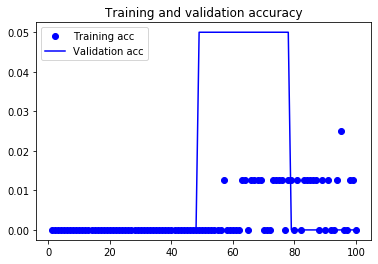

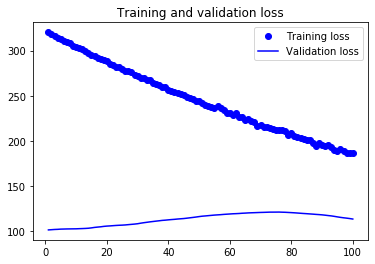

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s 4ms/step - loss: 1390.5906 - acc: 0.0000e+00 - val_loss: 1490.7858 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 529us/step - loss: 1387.4521 - acc: 0.0000e+00 - val_loss: 1491.3629 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 522us/step - loss: 1384.5040 - acc: 0.0000e+00 - val_loss: 1491.9894 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 522us/step - loss: 1380.6164 - acc: 0.0000e+00 - val_loss: 1492.8313 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 524us/step - loss: 1374.1837 - acc: 0.0000e+00 - val_loss: 1492.4039 - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 0s 542us/step - loss: 1373.0947 - acc: 0.0000e+00 - val_loss: 1492.0725 - val_acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 0s 532us/step - loss: 1

Epoch 56/100
80/80 [==============================] - 0s 519us/step - loss: 1211.2303 - acc: 0.0000e+00 - val_loss: 1555.3710 - val_acc: 0.0000e+00
Epoch 57/100
80/80 [==============================] - 0s 517us/step - loss: 1215.1827 - acc: 0.0000e+00 - val_loss: 1556.4277 - val_acc: 0.0000e+00
Epoch 58/100
80/80 [==============================] - 0s 515us/step - loss: 1202.2252 - acc: 0.0000e+00 - val_loss: 1557.4246 - val_acc: 0.0000e+00
Epoch 59/100
80/80 [==============================] - 0s 519us/step - loss: 1207.3624 - acc: 0.0000e+00 - val_loss: 1558.4974 - val_acc: 0.0000e+00
Epoch 60/100
80/80 [==============================] - 0s 528us/step - loss: 1195.5532 - acc: 0.0000e+00 - val_loss: 1559.3602 - val_acc: 0.0000e+00
Epoch 61/100
80/80 [==============================] - 0s 528us/step - loss: 1192.3803 - acc: 0.0000e+00 - val_loss: 1560.1013 - val_acc: 0.0000e+00
Epoch 62/100
80/80 [==============================] - 0s 537us/step - loss: 1194.0109 - acc: 0.0000e+00 - val_lo

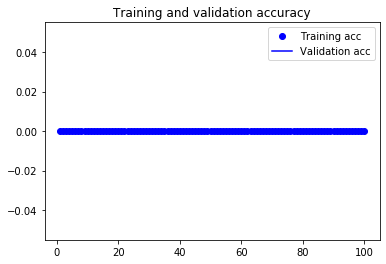

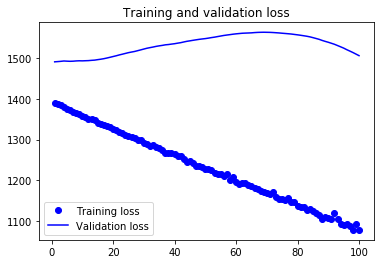

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s 4ms/step - loss: 96.3564 - acc: 0.0000e+00 - val_loss: 107.3869 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 525us/step - loss: 95.2219 - acc: 0.0000e+00 - val_loss: 106.5709 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 537us/step - loss: 93.9035 - acc: 0.0000e+00 - val_loss: 105.7978 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 522us/step - loss: 92.8456 - acc: 0.0000e+00 - val_loss: 104.9557 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 548us/step - loss: 91.5689 - acc: 0.0000e+00 - val_loss: 104.2598 - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 0s 538us/step - loss: 90.5501 - acc: 0.0000e+00 - val_loss: 103.6288 - val_acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 0s 546us/step - loss: 89.2670 - acc: 0.00

80/80 [==============================] - 0s 675us/step - loss: 48.9048 - acc: 0.0000e+00 - val_loss: 91.3018 - val_acc: 0.0000e+00
Epoch 58/100
80/80 [==============================] - 0s 562us/step - loss: 48.0864 - acc: 0.0000e+00 - val_loss: 90.9789 - val_acc: 0.0000e+00
Epoch 59/100
80/80 [==============================] - 0s 548us/step - loss: 47.8135 - acc: 0.0000e+00 - val_loss: 90.5838 - val_acc: 0.0000e+00
Epoch 60/100
80/80 [==============================] - 0s 578us/step - loss: 47.3287 - acc: 0.0000e+00 - val_loss: 90.1548 - val_acc: 0.0000e+00
Epoch 61/100
80/80 [==============================] - 0s 553us/step - loss: 46.8329 - acc: 0.0000e+00 - val_loss: 89.6669 - val_acc: 0.0000e+00
Epoch 62/100
80/80 [==============================] - 0s 530us/step - loss: 46.0836 - acc: 0.0000e+00 - val_loss: 89.1683 - val_acc: 0.0000e+00
Epoch 63/100
80/80 [==============================] - 0s 548us/step - loss: 45.5146 - acc: 0.0000e+00 - val_loss: 88.6217 - val_acc: 0.0000e+00
Epoch

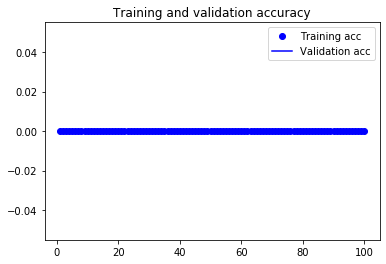

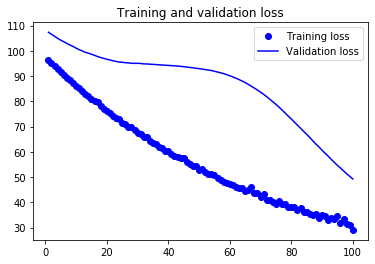

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s 4ms/step - loss: 301.6090 - acc: 0.0000e+00 - val_loss: 244.9242 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 550us/step - loss: 300.1319 - acc: 0.0000e+00 - val_loss: 242.5316 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 550us/step - loss: 298.4422 - acc: 0.0000e+00 - val_loss: 240.1947 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 613us/step - loss: 296.6436 - acc: 0.0000e+00 - val_loss: 237.8817 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 612us/step - loss: 295.0681 - acc: 0.0000e+00 - val_loss: 235.6174 - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 0s 537us/step - loss: 293.9854 - acc: 0.0000e+00 - val_loss: 233.2580 - val_acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 0s 537us/step - loss: 292.1150 - ac

Epoch 57/100
80/80 [==============================] - 0s 612us/step - loss: 222.9973 - acc: 0.0000e+00 - val_loss: 190.0415 - val_acc: 0.0000e+00
Epoch 58/100
80/80 [==============================] - 0s 1ms/step - loss: 221.1079 - acc: 0.0000e+00 - val_loss: 189.9031 - val_acc: 0.0000e+00
Epoch 59/100
80/80 [==============================] - 0s 1ms/step - loss: 218.7355 - acc: 0.0000e+00 - val_loss: 189.6751 - val_acc: 0.0000e+00
Epoch 60/100
80/80 [==============================] - 0s 1ms/step - loss: 220.8180 - acc: 0.0000e+00 - val_loss: 189.4668 - val_acc: 0.0000e+00
Epoch 61/100
80/80 [==============================] - 0s 1ms/step - loss: 221.3720 - acc: 0.0000e+00 - val_loss: 189.0929 - val_acc: 0.0000e+00
Epoch 62/100
80/80 [==============================] - 0s 1ms/step - loss: 216.6506 - acc: 0.0000e+00 - val_loss: 188.6166 - val_acc: 0.0000e+00
Epoch 63/100
80/80 [==============================] - 0s 1ms/step - loss: 215.6459 - acc: 0.0000e+00 - val_loss: 188.1805 - val_acc: 0

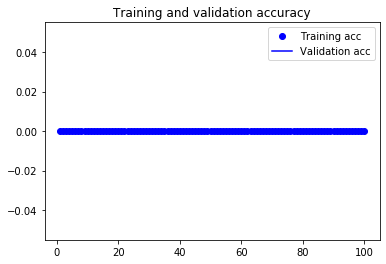

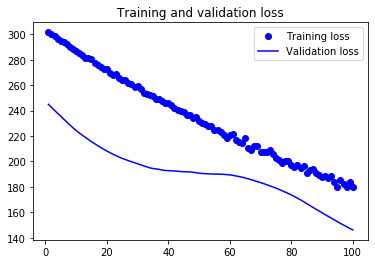

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s 5ms/step - loss: 1461.7142 - acc: 0.0000e+00 - val_loss: 807.0014 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 1ms/step - loss: 1459.1594 - acc: 0.0000e+00 - val_loss: 804.6087 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 1ms/step - loss: 1455.4901 - acc: 0.0000e+00 - val_loss: 802.1548 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 1ms/step - loss: 1451.4029 - acc: 0.0000e+00 - val_loss: 799.8216 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 1ms/step - loss: 1448.0715 - acc: 0.0000e+00 - val_loss: 797.7529 - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 0s 1ms/step - loss: 1443.6406 - acc: 0.0000e+00 - val_loss: 795.7974 - val_acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 0s 1ms/step - loss: 1439.7292 - acc: 0.

Epoch 57/100
80/80 [==============================] - 0s 1ms/step - loss: 1258.5384 - acc: 0.0000e+00 - val_loss: 809.0951 - val_acc: 0.0000e+00
Epoch 58/100
80/80 [==============================] - 0s 1ms/step - loss: 1249.2773 - acc: 0.0000e+00 - val_loss: 810.2810 - val_acc: 0.0000e+00
Epoch 59/100
80/80 [==============================] - 0s 1ms/step - loss: 1243.0526 - acc: 0.0000e+00 - val_loss: 811.7899 - val_acc: 0.0000e+00
Epoch 60/100
80/80 [==============================] - 0s 1ms/step - loss: 1245.2144 - acc: 0.0000e+00 - val_loss: 813.2469 - val_acc: 0.0000e+00
Epoch 61/100
80/80 [==============================] - 0s 1ms/step - loss: 1237.3551 - acc: 0.0000e+00 - val_loss: 814.7341 - val_acc: 0.0000e+00
Epoch 62/100
80/80 [==============================] - 0s 1ms/step - loss: 1231.6789 - acc: 0.0000e+00 - val_loss: 816.0739 - val_acc: 0.0000e+00
Epoch 63/100
80/80 [==============================] - 0s 1ms/step - loss: 1229.8230 - acc: 0.0000e+00 - val_loss: 817.4390 - val_a

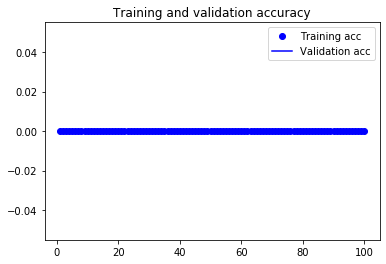

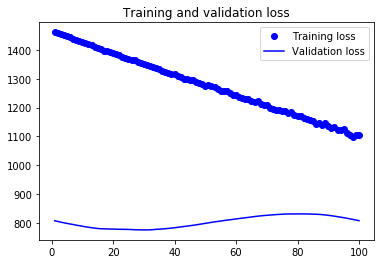

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s 5ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 8/100
80/80 [======

80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 62/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 63/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 64/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 65/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 66/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 67/100
80/80 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 68/100
80/80 [==============================] - 0s 1ms/step - loss: n

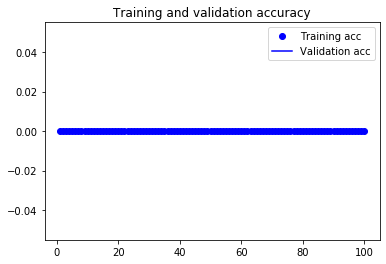

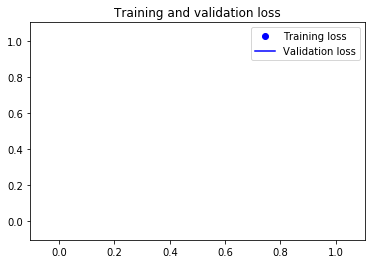

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s 5ms/step - loss: 0.9498 - acc: 0.0000e+00 - val_loss: 6.2836 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 563us/step - loss: 0.8886 - acc: 0.0000e+00 - val_loss: 6.8010 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 563us/step - loss: 0.8054 - acc: 0.0000e+00 - val_loss: 7.2872 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 761us/step - loss: 0.7663 - acc: 0.0000e+00 - val_loss: 7.7283 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - ETA: 0s - loss: 0.7272 - acc: 0.0000e+0 - 0s 1ms/step - loss: 0.7280 - acc: 0.0000e+00 - val_loss: 8.1448 - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - ETA: 0s - loss: 0.6082 - acc: 0.0000e+0 - 0s 1ms/step - loss: 0.6791 - acc: 0.0000e+00 - val_loss: 8.4554 - val_acc: 0.0000e+00
Epoch 7/100
80/80 [=============

80/80 [==============================] - 0s 1ms/step - loss: 0.4220 - acc: 0.0000e+00 - val_loss: 0.4040 - val_acc: 0.0000e+00
Epoch 58/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3909 - acc: 0.0000e+00 - val_loss: 0.3793 - val_acc: 0.0000e+00
Epoch 59/100
80/80 [==============================] - ETA: 0s - loss: 0.4846 - acc: 0.0000e+0 - 0s 1ms/step - loss: 0.3984 - acc: 0.0000e+00 - val_loss: 0.3524 - val_acc: 0.0000e+00
Epoch 60/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3915 - acc: 0.0000e+00 - val_loss: 0.3242 - val_acc: 0.0000e+00
Epoch 61/100
80/80 [==============================] - ETA: 0s - loss: 0.2312 - acc: 0.0000e+0 - 0s 1ms/step - loss: 0.4191 - acc: 0.0000e+00 - val_loss: 0.2932 - val_acc: 0.0000e+00
Epoch 62/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3926 - acc: 0.0000e+00 - val_loss: 0.2619 - val_acc: 0.0000e+00
Epoch 63/100
80/80 [==============================] - 0s 1ms/step - loss: 0.3812 - acc: 0

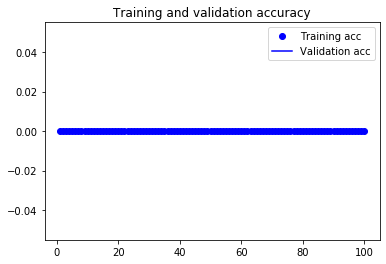

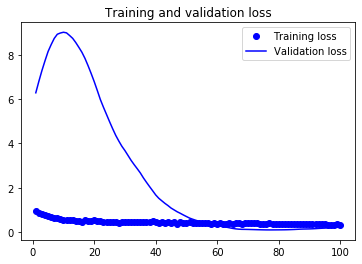

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s 4ms/step - loss: 657.4050 - acc: 0.0000e+00 - val_loss: 546.6952 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 573us/step - loss: 655.8851 - acc: 0.0000e+00 - val_loss: 541.4457 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 650us/step - loss: 653.1880 - acc: 0.0000e+00 - val_loss: 536.0968 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 744us/step - loss: 651.4188 - acc: 0.0000e+00 - val_loss: 530.9462 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 1ms/step - loss: 648.5251 - acc: 0.0000e+00 - val_loss: 525.8978 - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 0s 1ms/step - loss: 646.1339 - acc: 0.0000e+00 - val_loss: 521.1044 - val_acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 0s 1ms/step - loss: 644.3125 - acc: 0.0

80/80 [==============================] - 0s 1ms/step - loss: 535.9405 - acc: 0.0000e+00 - val_loss: 439.5025 - val_acc: 0.0000e+00
Epoch 58/100
80/80 [==============================] - 0s 1ms/step - loss: 534.2767 - acc: 0.0000e+00 - val_loss: 439.4110 - val_acc: 0.0000e+00
Epoch 59/100
80/80 [==============================] - 0s 1ms/step - loss: 531.3048 - acc: 0.0000e+00 - val_loss: 439.3517 - val_acc: 0.0000e+00
Epoch 60/100
80/80 [==============================] - 0s 1ms/step - loss: 530.4085 - acc: 0.0000e+00 - val_loss: 439.4315 - val_acc: 0.0000e+00
Epoch 61/100
80/80 [==============================] - 0s 1ms/step - loss: 528.8415 - acc: 0.0000e+00 - val_loss: 439.4802 - val_acc: 0.0000e+00
Epoch 62/100
80/80 [==============================] - 0s 1ms/step - loss: 529.3300 - acc: 0.0000e+00 - val_loss: 439.8157 - val_acc: 0.0000e+00
Epoch 63/100
80/80 [==============================] - 0s 1ms/step - loss: 522.1468 - acc: 0.0000e+00 - val_loss: 439.9064 - val_acc: 0.0000e+00
Epoch

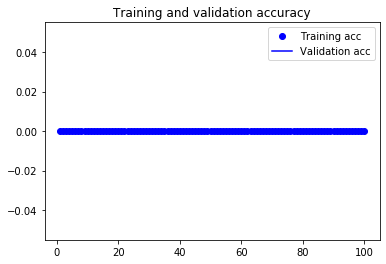

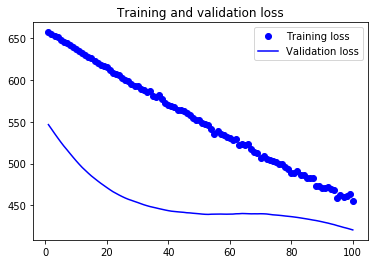

In [43]:
for i in data:
    features, target = i[0], i[1]
    features = np.array(features)
    target = np.array(target)
    model = Net()
    train(features, target, model)